Starter code taken from this online blog post

https://towardsdatascience.com/network-analysis-to-quickly-get-insight-into-an-academic-field-with-python-cd891717d547

In [1]:
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm

# Change this email to your email address
Entrez.email = "awyeh450471@gmail.com"

keyword = "optical trap"

result = Entrez.read(Entrez.esearch(db="pubmed", retmax=10, term=keyword))
print(
    "Total number of publications that contain the term {}: {}".format(
        keyword, result["Count"]
    )
)

# Fetch all ids
MAX_COUNT = result["Count"]
result = Entrez.read(
    Entrez.esearch(db="pubmed", retmax=result["Count"], term=keyword)
)

ids = result["IdList"]

batch_size = 100
batches = [ids[x: x + 100] for x in range(0, len(ids), batch_size)]

record_list = []
for batch in tqdm(batches):
    h = Entrez.efetch(db="pubmed", id=batch, rettype="medline", retmode="text")
    records = Medline.parse(h)
    record_list.extend(list(records))
print("Complete.")

Total number of publications that contain the term optical trap: 5961


100%|██████████████████████████████████████████| 60/60 [01:35<00:00,  1.59s/it]

Complete.


In [2]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("white")

publication_data = pd.DataFrame(record_list)
publication_data.dropna(subset=['EDAT'], inplace=True)
publication_data["Year"] = (
    publication_data["EDAT"].astype(str).str[0:4].astype(int)
)

plt.figure(figsize=(10, 10), dpi=600)

# Top 10 authors
plt.subplot(2, 2, 1)
authors_flat = [
    author
    for authors in list(publication_data["FAU"].dropna())
    for author in authors
]
top10authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(10), columns=["Name", "Count"]
)
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")


# Publications over Time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(publication_data["Year"].value_counts().reset_index())
yearly.columns = ["Year", "Count"]
sns.lineplot(x="Year", y="Count", data=yearly)
plt.title("Publications over Time")
plt.xlim([1986, 2020])


plt.subplot(2, 2, 3)

# TOP 10 Journals
top10journals = pd.DataFrame.from_records(
    Counter(publication_data["TA"]).most_common(10),
    columns=["Journal", "Count"],
)

sns.barplot(x="Count", y="Journal", data=top10journals, palette="RdBu_r")
plt.title("Top 10 Journals")

# Top associated keywords
plt.subplot(2, 2, 4)

flat_kw = [
    _.lower()
    for kws in list(publication_data["OT"].dropna())
    for kw in kws
    for _ in kw.split(" ")
]

top10kw = pd.DataFrame.from_records(
    Counter(flat_kw).most_common(10), columns=["Keyword", "Count"]
)

sns.barplot(x="Count", y="Keyword", data=top10kw, palette="RdBu_r")
plt.title("Top 10 Associated Keywords")
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.3, wspace=0.3)
plt.show()

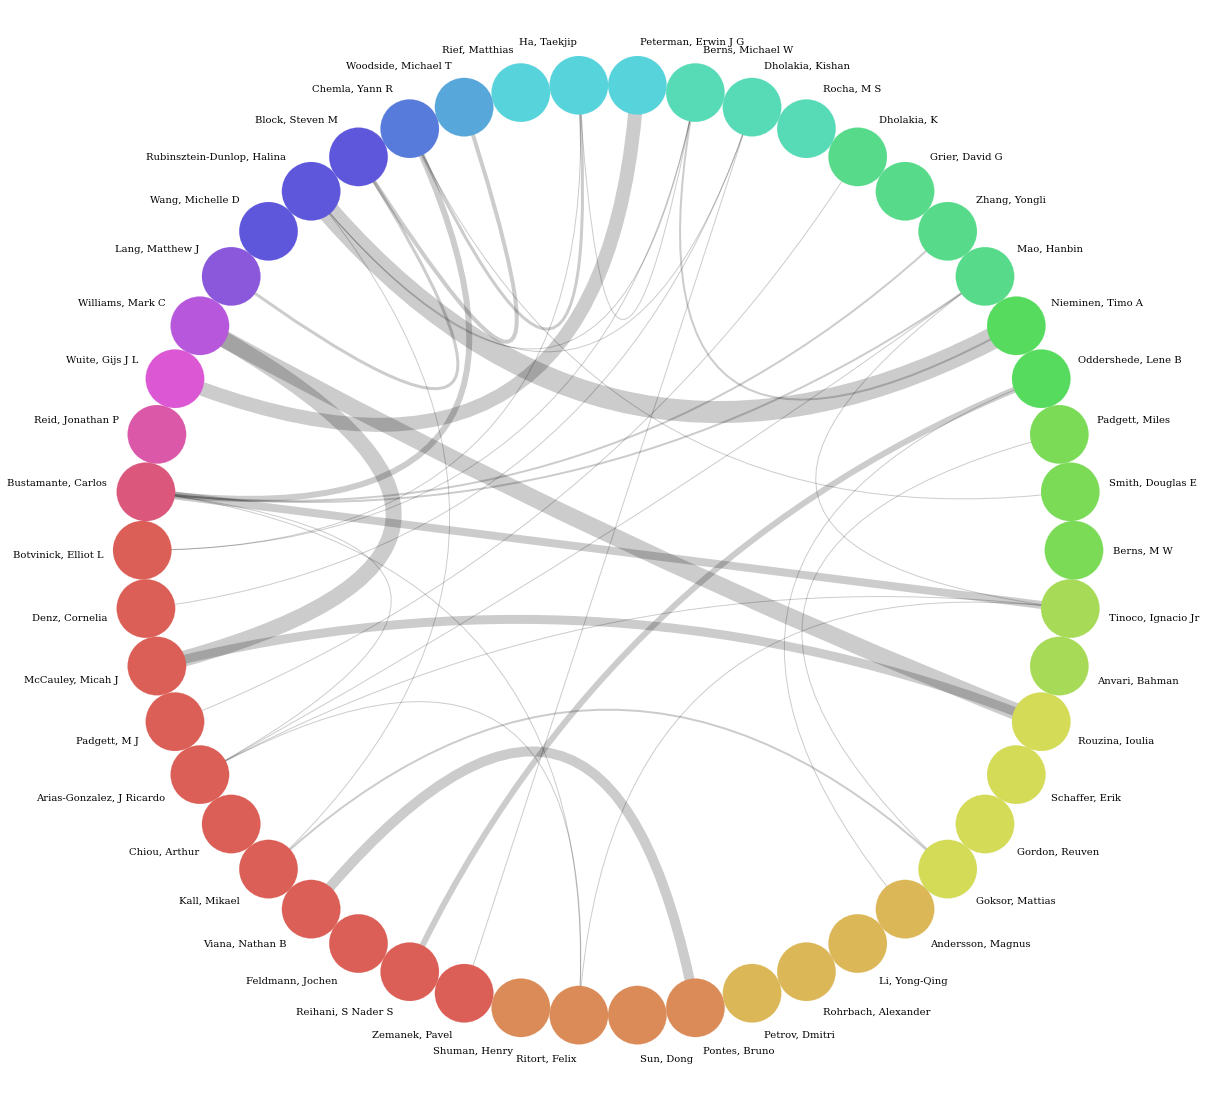

In [3]:
from itertools import combinations
import networkx as nx
from nxviz.plots import CircosPlot

# Extract author connections
authors = publication_data["FAU"].dropna()
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors)
)
flat_connections = [item for sublist in author_connections for item in sublist]

# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]


G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="Count"
)

# Limit to TOP 50 authors
top50authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(50), columns=["Name", "Count"]
)

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))

G_50 = G.subgraph(top50_nodes)

for n in G_50.nodes():
    G_50.nodes[n]["publications"] = int(
        top50authors[top50authors["Name"] == n]["Count"]
    )


c = CircosPlot(
    G_50,
    dpi=600,
    node_grouping="publications",
    edge_width="Count",
    figsize=(20, 20),
    node_color="publications",
    node_labels=True,
)
c.draw()
plt.show()

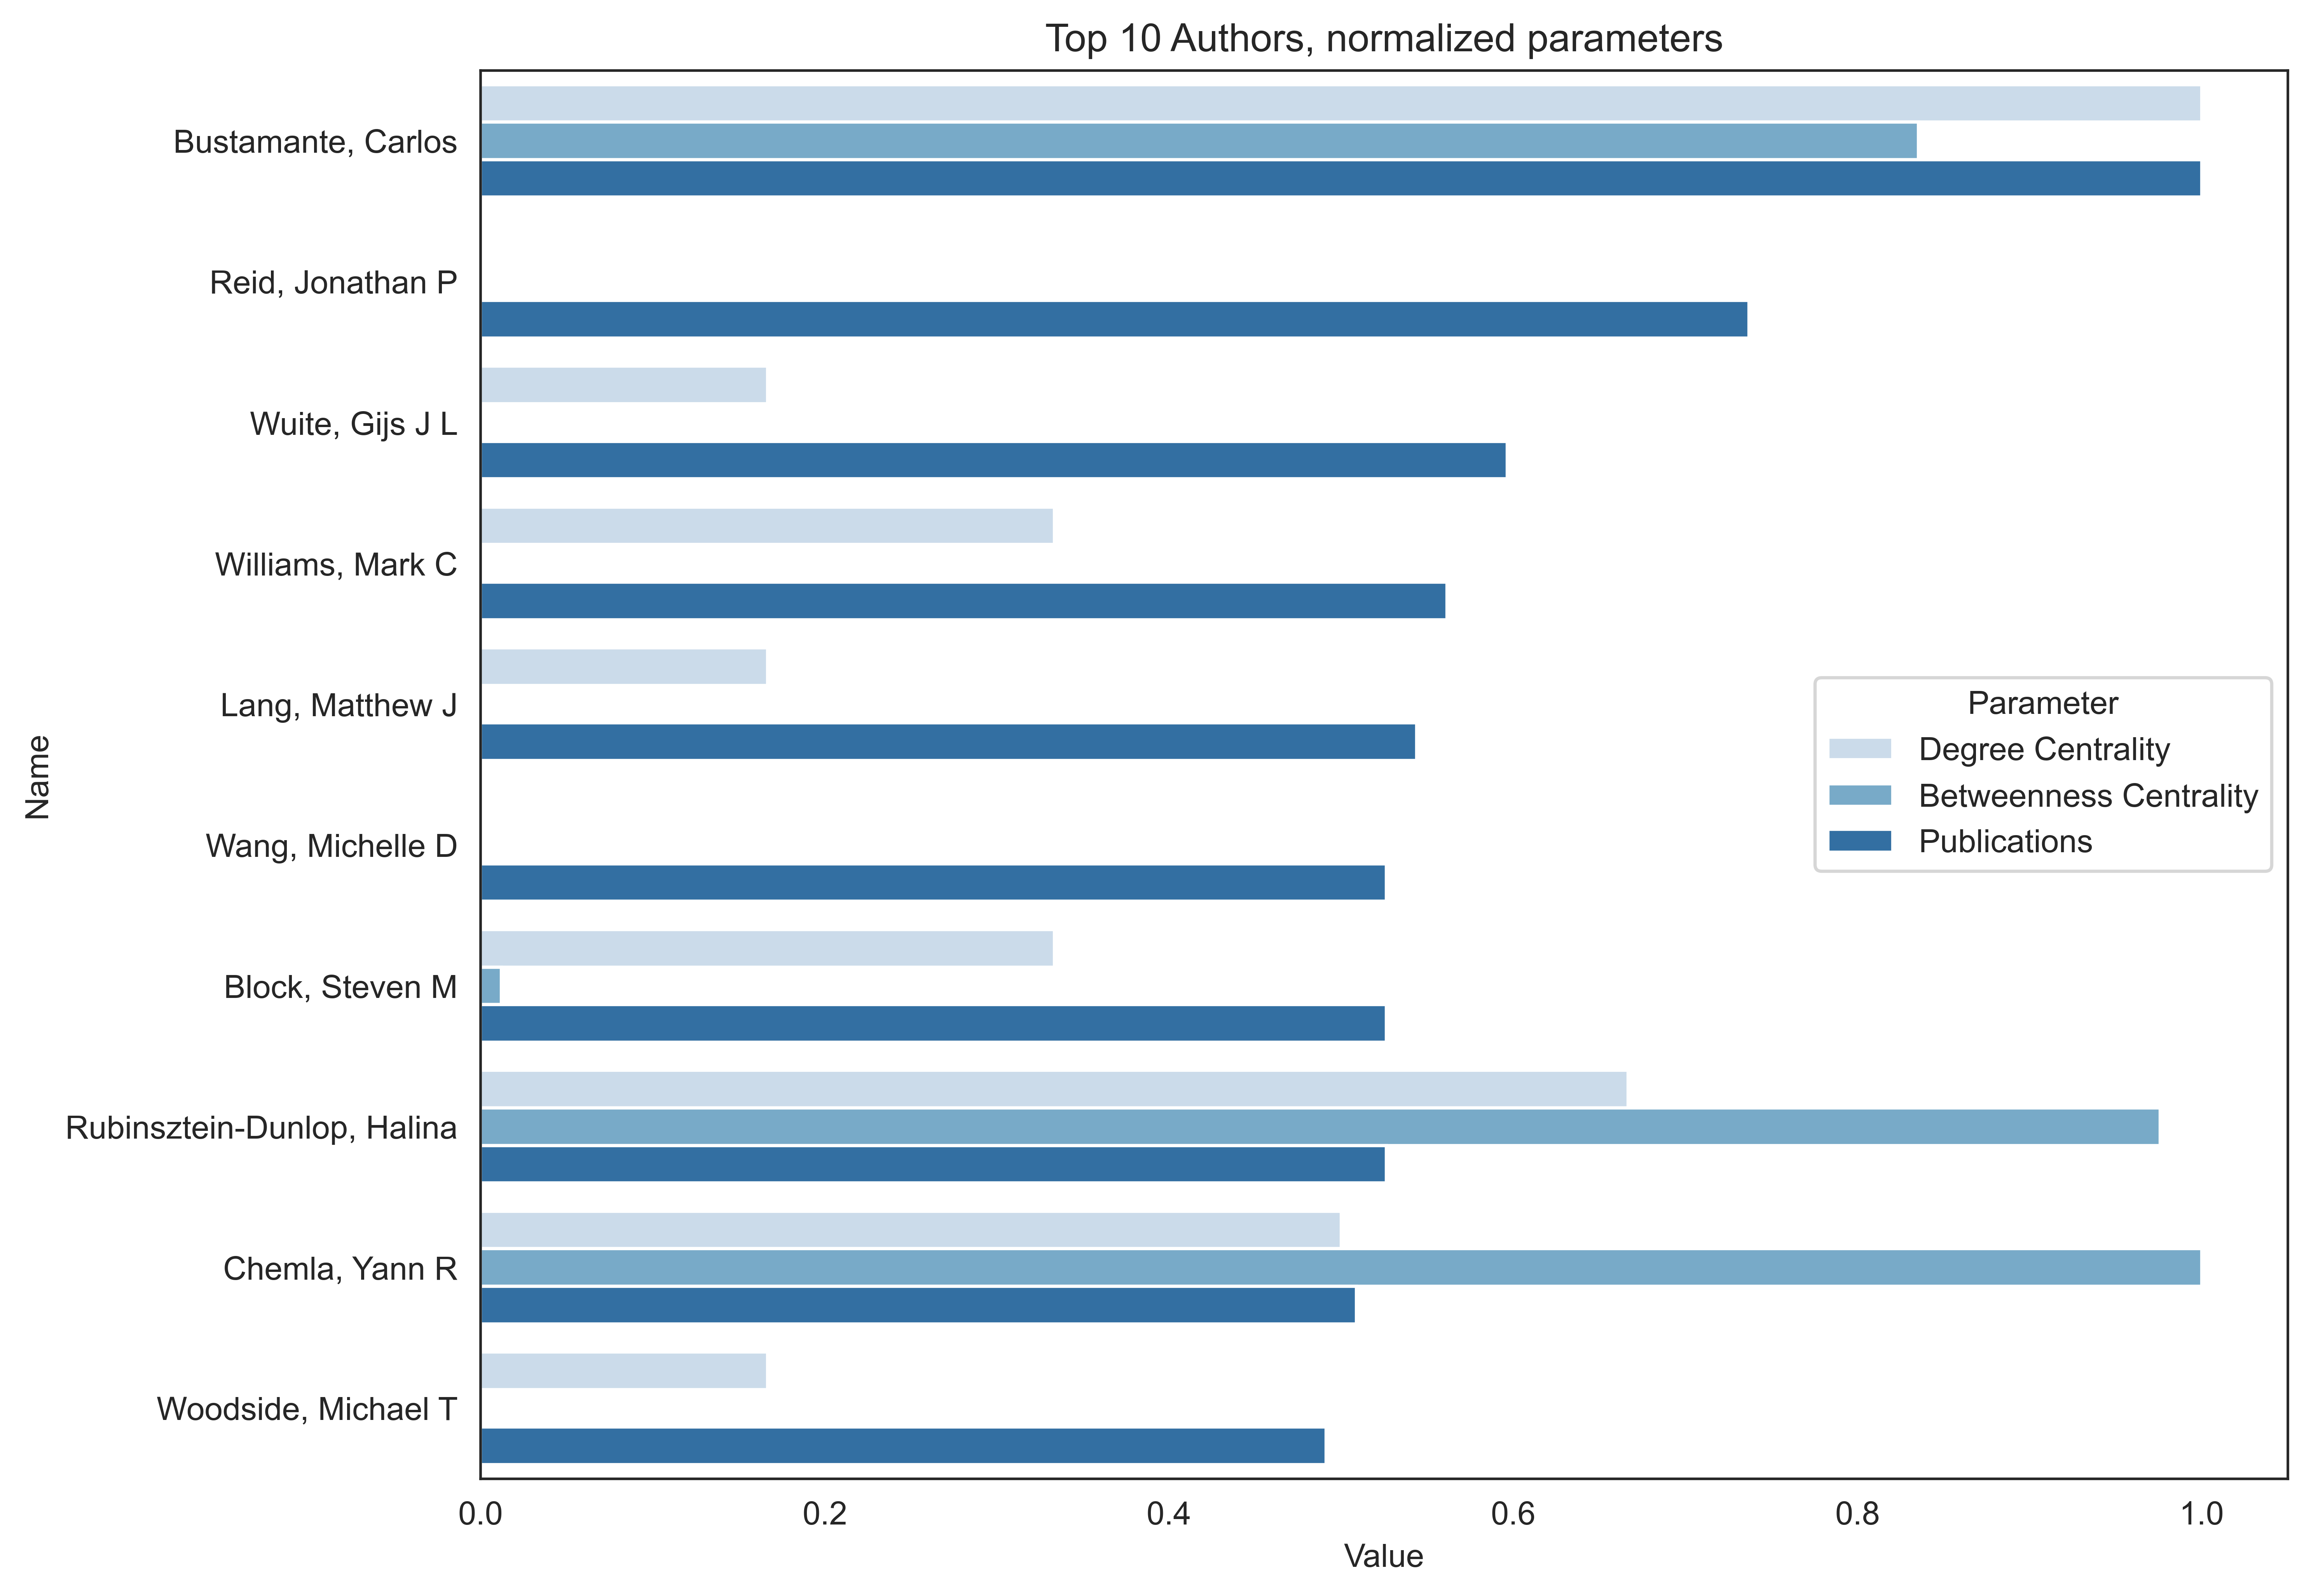

In [4]:
## Network analysis
deg = nx.degree_centrality(G_50)
bet = nx.betweenness_centrality(G_50)

top_df = pd.DataFrame.from_dict(
    [deg, bet, dict(Counter(authors_flat).most_common(50))]
).T
top_df.columns = [
    "Degree Centrality",
    "Betweenness Centrality",
    "Publications",
]

for col in top_df.columns:
    top_df[col] = top_df[col] / max(top_df[col])

top_df = top_df.sort_values("Publications", ascending=False)[:10]
top_df = pd.DataFrame(top_df.stack())
top_df = top_df.reset_index()
top_df.columns = ["Name", "Parameter", "Value"]


fig, ax = plt.subplots(figsize=(10, 8), dpi=600)

sns.barplot(x="Value", y="Name", data=top_df, hue="Parameter", palette="Blues")

plt.title("Top 10 Authors, normalized parameters")
plt.show()

In [5]:
paths = list(
    nx.all_shortest_paths(G, source="Ha, Taekjip", target="Bustamante, Carlos")
)

for path in paths:
    print(path)

['Ha, Taekjip', 'Chemla, Yann R', 'Bustamante, Carlos']
['Ha, Taekjip', 'Yu, Jin', 'Bustamante, Carlos']


In [11]:
publication_data.columns

Index(['PMID', 'OWN', 'STAT', 'LR', 'IS', 'VI', 'DP', 'TI', 'PG', 'LID', 'AB',
       'CI', 'FAU', 'AU', 'AD', 'LA', 'PT', 'DEP', 'PL', 'TA', 'JT', 'JID',
       'PMC', 'OTO', 'OT', 'EDAT', 'MHDA', 'CRDT', 'PHST', 'AID', 'PST', 'SO',
       'SB', 'IP', 'COIS', 'AUID', 'GR', 'DCOM', 'RN', 'MH', 'PMCR', 'EIN',
       'MID', 'CIN', 'EFR', 'SI', 'CON', 'CN', 'IR', 'FIR', 'TT', 'RIN', 'ECI',
       'OID', 'DA', 'ISBN', 'PB', 'BTI', 'CP', 'FED', 'ED', 'CDAT', 'RPF',
       'GN', 'PS', 'FPS', 'DRDT', 'CTDT', 'RF', 'RPI', 'GS', 'Year'],
      dtype='object')

In [17]:
publication_data['RF'].shape

(5961,)

In [25]:
publication_data.dropna(subset = ['RF'])['RF'].astype(int).sort_values(ascending = False).reset_index(drop = True)

0      200
1      190
2      186
3      180
4      161
      ... 
114     15
115     15
116     13
117     13
118      8
Name: RF, Length: 119, dtype: int32

In [14]:
publication_data.sort_values(by = ['RF'], ascending = True)

,PMID,OWN,STAT,LR,IS,VI,DP,TI,PG,LID,...,RPF,GN,PS,FPS,DRDT,CTDT,RF,RPI,GS,Year
5836,8528770,NLM,MEDLINE,20191023,0959-440X (Print) 0959-440X (Linking),5,1995 Aug,The morphology of lipid membranes.,531-40,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,103,NaN,NaN,1995
5573,11733041,NLM,MEDLINE,20191105,1398-9219 (Print) 1398-9219 (Linking),2,2001 Nov,Using optics to measure biological forces and ...,757-63,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,104,NaN,NaN,2001
4860,17328679,NLM,MEDLINE,20181113,1056-8700 (Print) 1056-8700 (Linking),36,2007,"High-resolution, single-molecule measurements ...",171-90,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,118,NaN,NaN,2007
4372,19153991,NLM,MEDLINE,20131121,1613-6829 (Electronic) 1613-6810 (Linking),5,2009 Feb,Core/Shell semiconductor nanocrystals.,154-68,10.1002/smll.200800841 [doi],...,NaN,NaN,NaN,NaN,NaN,NaN,124,NaN,NaN,2009
5918,1577585,NLM,MEDLINE,20190918,0074-7696 (Print) 0074-7696 (Linking),133,1992,"Manipulation of cells, organelles, and genomes...",1-41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,124,NaN,NaN,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5956,20333077,NLM,PubMed-not-MEDLINE,20181023,1559-128X (Print) 1559-128X (Linking),20,1981 Sep 1,Luminescent solar concentrators and the reabso...,2934-40,10.1364/AO.20.002934 [doi],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1981
5957,471376,NLM,MEDLINE,20091026,0029-7844 (Print) 0029-7844 (Linking),54,1979 Sep,Contact hysteroscopy: a new technique to explo...,350-4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1979
5958,33964,NLM,MEDLINE,20200724,0021-9193 (Print) 0021-9193 (Linking),137,1979 Feb,Oxidation of carbon monoxide in cell extracts ...,811-7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1979
5959,4830466,NLM,MEDLINE,20181113,0006-3495 (Print) 0006-3495 (Linking),14,1974 Apr,Probing photosynthesis on a picosecond time sc...,269-83,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1974


In [28]:
publication_data['OT'][0]

['Stark effect',
 'nanocrystals',
 'perovskite',
 'spectroscopy',
 'surface',
 'transient absorption',
 'ultrafast']